<a href="https://colab.research.google.com/github/SubstanceIsFormAndContent/Cellular-Automata/blob/master/notebooks/ConvVarAutoEnc_ctts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install importlib-metadata==4.10.0
!pip install twine
!pip install blackcellmagic watermark
%load_ext blackcellmagic
# Load the TensorBoard notebook extension
%load_ext tensorboard

  Using cached importlib_metadata-4.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 2.1.2
    Uninstalling importlib-metadata-2.1.2:
      Successfully uninstalled importlib-metadata-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
watermark 2.2.0 requires importlib-metadata<3.0; python_version < "3.8", but you have importlib-metadata 4.10.0 which is incompatible.
  Using cached importlib_metadata-2.1.2-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

In [ ]:
import numpy as np

import keras
import keras.backend as K
from keras import Model, losses, callbacks
from keras.layers import Conv2D, Dense, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Reshape, Lambda, Add

import tensorflow.keras.datasets.mnist as mnist

import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [ ]:
# First, the typically annoying process of getting the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
# Intention: Build a class to train and test a specific type. In this case, the CAE [ConvolutionalAutoEncoder]

In [ ]:
def manhattan_distance(y_train,y_pred):
   distance = K.abs(y_train-y_pred)
   return Reshape((28, 28))(distance)

def eucledian_distance(y_train, y_pred):
    distance_squared = K.square(y_train) + K.square(y_pred)
    distance = K.sqrt(distance_squared)
    return Reshape((28, 28))(distance)

def custom_loss_fn(y_train, y_pred, test=False):
    mse = losses.mean_squared_error(y_train, y_pred)
    mloss = manhattan_distance(y_train, y_pred)
    eloss = eucledian_distance(y_train, y_pred)

    if test:
        print(f'MSE SHAPE: {mse.shape} -- MLOSS SHAPE: {mloss.shape} -- ELOSS SHAPE: {eloss.shape}')
        return mse, mloss, eloss

    return K.sqrt(Add()([mloss, eloss]))

mse, mloss, eloss = custom_loss_fn(x_train, x_train, test=True)

In [ ]:
LATENT_SIDE = 7
LATENET_SIZE = LATENT_SIDE ** 2

In [ ]:
def create_model(loss_fn=None, summary=False, metrics=['mse', custom_loss_fn]):
    input_img = keras.Input(shape=(28, 28, 1))

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(92, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(49, activation='sigmoid')(x)

    # at this point the representation is 49 latent reps

    x = Dense(128, activation='relu')(encoded)
    x = Reshape((4,4,8))(x)
    x = Conv2D(92, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder_model = Model(input_img, decoded)
    encoder_model = Model(input_img, encoded)
    decoder_model = Model(encoded, decoded)
    if loss_fn:
        autoencoder_model.compile(optimizer='adam', loss=loss_fn, metrics=metrics)
    else:
        autoencoder_model.compile(optimizer='adam', loss='mse', metrics=metrics)
    if summary: autoencoder_model.summary()
    return encoder_model, decoder_model, autoencoder_model

In [ ]:
logdir = "logs/autoencoder_ctts"
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)

%load_ext tensorboard
%tensorboard --logdir logs/autoencoder_ctts
import tensorboard

tensorboard.notebook.list() # View open TensorBoard instances


# the most recently launched TensorBoard is used
tensorboard.notebook.display(port=6006, height=1000) 

def train_model(epochs=5, batch_size=128, loss_fn=None, summary=False, callbacks=[tensorboard_callback]):
    encoder_model, decoder_model, autoencoder_model = create_model(loss_fn)
    
    autoencoder_model.fit(x=x_train,
                          y=x_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          callbacks=callbacks)
    

    return encoder_model, decoder_model, autoencoder_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 323), started 4:13:00 ago. (Use '!kill 323' to kill it.)

<IPython.core.display.Javascript object>

Known TensorBoard instances:
  - port 6006: logdir logs/autoencoder_ctts (started 4:13:00 ago; pid 323)
  - port 6006: logdir logs/autoencoder_ctts (started 3:59:40 ago; pid 609)
Selecting TensorBoard with logdir logs/autoencoder_ctts (started 3:59:40 ago; port 6006, pid 609).


<IPython.core.display.Javascript object>

In [ ]:
basic_encoder_model, basic_decoder_model, basic_autoencoder_model = train_model()

Epoch 1/5
469/469 [==============================] - 362s 762ms/step - loss: 0.0435 - mse: 0.0435 - custom_loss_fn: 0.3726 - val_loss: 0.0464 - val_mse: 0.0464 - val_custom_loss_fn: 0.2589
Epoch 2/5
469/469 [==============================] - 349s 743ms/step - loss: 0.0129 - mse: 0.0129 - custom_loss_fn: 0.2435 - val_loss: 0.0141 - val_mse: 0.0141 - val_custom_loss_fn: 0.2542
Epoch 3/5
469/469 [==============================] - 341s 726ms/step - loss: 0.0102 - mse: 0.0102 - custom_loss_fn: 0.2309 - val_loss: 0.0100 - val_mse: 0.0100 - val_custom_loss_fn: 0.2384
Epoch 4/5
469/469 [==============================] - 350s 746ms/step - loss: 0.0089 - mse: 0.0089 - custom_loss_fn: 0.2255 - val_loss: 0.0099 - val_mse: 0.0099 - val_custom_loss_fn: 0.2294
Epoch 5/5
469/469 [==============================] - 353s 753ms/step - loss: 0.0080 - mse: 0.0080 - custom_loss_fn: 0.2220 - val_loss: 0.0087 - val_mse: 0.0087 - val_custom_loss_fn: 0.2234


In [ ]:
mloss_encoder_model, mloss_decoder_model, mloss_autoencoder_model = train_model(loss_fn=custom_loss_fn)

Epoch 1/5
469/469 [==============================] - 356s 755ms/step - loss: 0.4058 - mse: 0.0523 - custom_loss_fn: 0.4058 - val_loss: 0.4793 - val_mse: 0.0744 - val_custom_loss_fn: 0.4793
Epoch 2/5
469/469 [==============================] - 344s 734ms/step - loss: 0.2845 - mse: 0.0188 - custom_loss_fn: 0.2845 - val_loss: 0.2849 - val_mse: 0.0143 - val_custom_loss_fn: 0.2849
Epoch 3/5
469/469 [==============================] - 341s 727ms/step - loss: 0.2735 - mse: 0.0146 - custom_loss_fn: 0.2735 - val_loss: 0.2783 - val_mse: 0.0131 - val_custom_loss_fn: 0.2783
Epoch 4/5
469/469 [==============================] - 342s 730ms/step - loss: 0.2685 - mse: 0.0127 - custom_loss_fn: 0.2685 - val_loss: 0.2730 - val_mse: 0.0143 - val_custom_loss_fn: 0.2730
Epoch 5/5
469/469 [==============================] - 345s 737ms/step - loss: 0.2655 - mse: 0.0116 - custom_loss_fn: 0.2655 - val_loss: 0.2713 - val_mse: 0.0114 - val_custom_loss_fn: 0.2713


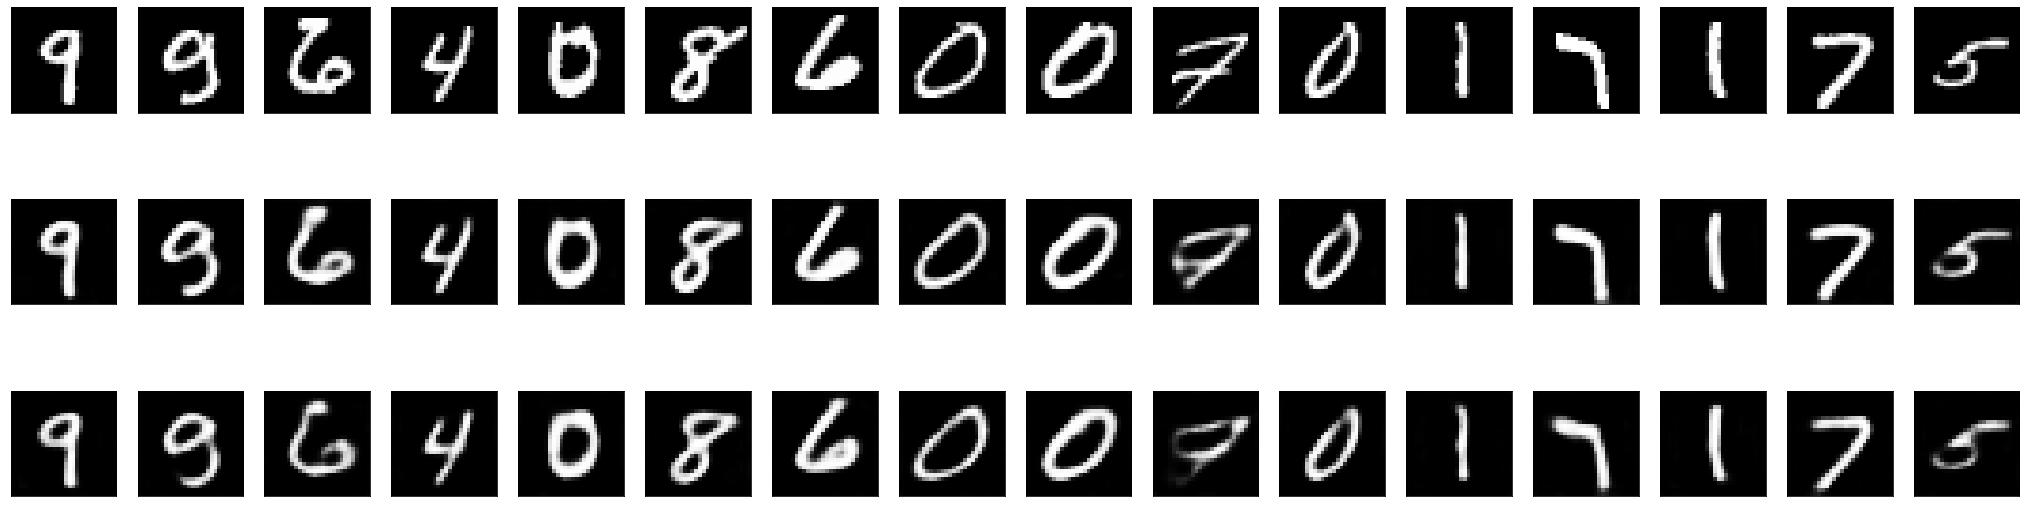

In [ ]:
n = 16
sample = x_test[np.random.randint(0, len(x_test), size=n)]
basic_decoded_imgs = basic_autoencoder_model.predict(sample)
mloss_decoded_imgs = mloss_autoencoder_model.predict(sample)

plt.figure(figsize=(36, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(sample[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display basic reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(basic_decoded_imgs[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display custom reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(mloss_decoded_imgs[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
import time
from tqdm import tqdm, trange
from IPython.display import HTML
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def get_random_digit():
    idx = np.random.randint(0, x_train.shape[0]-1)
    seed_digit = np.array(x_train[idx:idx+1])
    return seed_digit, seed_digit

basic_seed_digit, mloss_seed_digit = get_random_digit()

# create a figure and axes
fig = plt.figure(figsize=(12,6))
plt.title('Comparison of different training quality for generation')
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
ax1.set_title('mse')
ax2.set_title('mse + mloss')
left_img = ax1.imshow(np.zeros((28,28))) 
right_img = ax2.imshow(np.zeros((28,28)))
# don't show the plain background
#plt.close()


frames = []
for idx in trange(10000):

    basic_digit_rep = basic_encoder_model(basic_seed_digit, training=False)
    basic_projected_digit = basic_decoder_model(basic_digit_rep, training=False)

    mloss_digit_rep = mloss_encoder_model(mloss_seed_digit, training=False)
    mloss_projected_digit = mloss_decoder_model(mloss_digit_rep, training=False)

    left_img = ax1.imshow(basic_projected_digit.reshape((28,28)))
    right_img = ax2.imshow(mloss_projected_digit.reshape((28,28)))

    frames.append([left_img, right_img])

    if not idx % 100:
        basic_seed_digit, mloss_seed_digit = get_random_digit()
    else:
        basic_seed_digit = basic_projected_digit
        mloss_seed_digit = mloss_projected_digit

anim = animation.ArtistAnimation(fig, frames, interval=20, blit=True, repeat_delay=500)
HTML(anim.to_html5_video())

100%|██████████| 10000/10000 [07:35<00:00, 21.95it/s]


In [ ]:
mse, mloss, eloss = custom_loss_fn(x_train[:20],x_train[1:21], test=True)
tloss = Add()([mse, eloss, mloss])

In [30]: n = 16
    ...: 
    ...: plt.figure(figsize=(36, 10))
    ...: for i in range(1, n + 1):
    ...:     # Display original
    ...:     ax = plt.subplot(4, n, i)
    ...:     plt.imshow(tloss[i-1])
    ...:     plt.gray()
    ...:     ax.get_xaxis().set_visible(False)
    ...:     ax.get_yaxis().set_visible(False)
    ...: 
    ...:     # Display basic reconstruction
    ...:     ax = plt.subplot(4, n, i+n)
    ...:     plt.imshow(mse[i-1])
    ...:     plt.gray()
    ...:     ax.get_xaxis().set_visible(False)
    ...:     ax.get_yaxis().set_visible(False)
    ...: 
    ...:     # Display custom reconstruction
    ...:     ax = plt.subplot(4, n, i+2*n)
    ...:     plt.imshow(mloss[i-1])
    ...:     plt.gray()
    ...:     ax.get_xaxis().set_visible(False)
    ...:     ax.get_yaxis().set_visible(False)
    ...: 
    ...: # Display custom reconstruction
    ...:     ax = plt.subplot(4, n, i+3*n)
    ...:     plt.imshow(eloss[i-1])
    ...:     plt.gray()
    ...:     ax.get_xaxis().set_visible(False)
    ...:     ax.get_yaxis().set_visible(False)
    ...: plt.show()